In [22]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
 
import numpy as np
import matplotlib.pyplot as plt
import os
 
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [23]:
dataset = '.'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
 
batch_size = 32
num_classes = 40
 
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
 
}
 
 
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
 
train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
 
print(train_data_size, valid_data_size)

17169 2375


In [24]:
resnet50 = models.resnet50(pretrained=True)

In [25]:
for param in resnet50.parameters():
    param.requires_grad = False

In [26]:
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 40),
    nn.LogSoftmax(dim=1)
)

In [27]:
resnet50 = resnet50.to('cuda:0')

In [28]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [29]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    history = []
    best_acc = 0.0
    best_epoch = 0
 
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
 
        model.train()
 
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
 
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            #因为这里梯度是累加的，所以每次记得清零
            optimizer.zero_grad()
 
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            loss.backward()
 
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            train_acc += acc.item() * inputs.size(0)
 
        with torch.no_grad():
            model.eval()
 
            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
 
                loss = loss_function(outputs, labels)
 
                valid_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                valid_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_valid_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
 
        torch.save(model, 'models/'+dataset+'_model_'+str(epoch+1)+'.pt')
    return model, history

Epoch: 1/70
Epoch: 001, Training: Loss: 0.7430, Accuracy: 53.3927%, 
		Validation: Loss: 0.7430, Accuracy: 78.4421%, Time: 108.7465s
Best Accuracy for validation : 0.7844 at epoch 001
Epoch: 2/70
Epoch: 002, Training: Loss: 0.6486, Accuracy: 66.6259%, 
		Validation: Loss: 0.6486, Accuracy: 81.4316%, Time: 107.7427s
Best Accuracy for validation : 0.8143 at epoch 002
Epoch: 3/70
Epoch: 003, Training: Loss: 0.6216, Accuracy: 69.4391%, 
		Validation: Loss: 0.6216, Accuracy: 81.2211%, Time: 109.0397s
Best Accuracy for validation : 0.8143 at epoch 002
Epoch: 4/70
Epoch: 004, Training: Loss: 0.5536, Accuracy: 70.5225%, 
		Validation: Loss: 0.5536, Accuracy: 83.7053%, Time: 110.1391s
Best Accuracy for validation : 0.8371 at epoch 004
Epoch: 5/70
Epoch: 005, Training: Loss: 0.5530, Accuracy: 71.2097%, 
		Validation: Loss: 0.5530, Accuracy: 83.7474%, Time: 111.4444s
Best Accuracy for validation : 0.8375 at epoch 005
Epoch: 6/70
Epoch: 006, Training: Loss: 0.6011, Accuracy: 72.0834%, 
		Validatio

Epoch: 046, Training: Loss: 0.5364, Accuracy: 78.3796%, 
		Validation: Loss: 0.5364, Accuracy: 84.9684%, Time: 108.0542s
Best Accuracy for validation : 0.8699 at epoch 045
Epoch: 47/70
Epoch: 047, Training: Loss: 0.4957, Accuracy: 78.1350%, 
		Validation: Loss: 0.4957, Accuracy: 85.4737%, Time: 108.2952s
Best Accuracy for validation : 0.8699 at epoch 045
Epoch: 48/70
Epoch: 048, Training: Loss: 0.4927, Accuracy: 78.8223%, 
		Validation: Loss: 0.4927, Accuracy: 85.9368%, Time: 108.1630s
Best Accuracy for validation : 0.8699 at epoch 045
Epoch: 49/70
Epoch: 049, Training: Loss: 0.5210, Accuracy: 78.2806%, 
		Validation: Loss: 0.5210, Accuracy: 85.8105%, Time: 109.0517s
Best Accuracy for validation : 0.8699 at epoch 045
Epoch: 50/70
Epoch: 050, Training: Loss: 0.4995, Accuracy: 78.9563%, 
		Validation: Loss: 0.4995, Accuracy: 86.0632%, Time: 108.3697s
Best Accuracy for validation : 0.8699 at epoch 045
Epoch: 51/70
Epoch: 051, Training: Loss: 0.4911, Accuracy: 78.1117%, 
		Validation: Loss

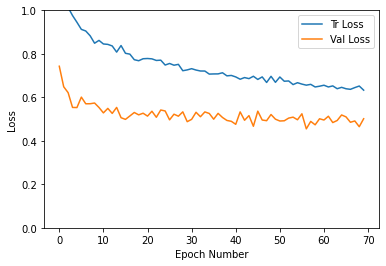

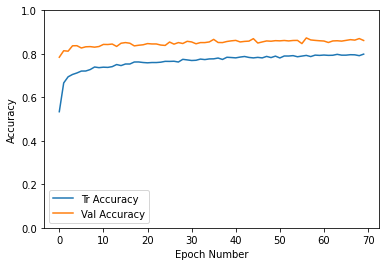

In [30]:
num_epochs = 70
trained_model, history = train_and_valid(resnet50, loss_func, optimizer, num_epochs)
torch.save(history, 'models/'+dataset+'_history.pt')
 
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()